In [893]:
import gzip
import pandas
import matplotlib.pyplot as plt;
import matplotlib
import numpy as np
import ujson;
import json;
import importlib
import bgzf
import struct
import os

from tqdm.auto import tqdm
from os.path import join as PJ


#Set the data path to INSPIRE
dataPath = PJ("..","Data","INSPIRE","20210108","Processed")
os.makedirs(dataPath, exist_ok=True)

%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [894]:
def savebgzip(filepath,entries):
  with bgzf.open(filepath,"wb") as fd:
      for entry in tqdm(entries):
          data = ujson.dumps(entry).encode("utf8");
          fd.write(struct.pack("<Q",len(data)))
          fd.write(data)
          
def loadbgzip(filepath,estimated=1362493):
  entries=[];
  with bgzf.open(filepath,"rb") as fd:
    pbar = tqdm(total=estimated);
    while True:
        pbar.update(1);
        sizeBuffer = fd.read(8*1);
        if(len(sizeBuffer)==8*1):
            dataSize = struct.unpack("<Q",sizeBuffer)[0];
            data = fd.read(dataSize);
            entry = ujson.loads(data.decode("utf8"));
            entries.append(entry);
        else:
            break; 
  return entries;

In [895]:
HEPBGZ = processedBGZ = PJ(dataPath,"HEP.bgzip");
institutionsBGZ = PJ(dataPath,"Institutions.bgzip");
dataBGZ = PJ(dataPath,"Data.bgzip");
namesBGZ = PJ(dataPath,"Names.bgzip");
jobsBGZ = PJ(dataPath,"Jobs-records.bgzip");

In [896]:
HEPEntries = loadbgzip(HEPBGZ,estimated = 1404482);
institutionsEntries = loadbgzip(institutionsBGZ,estimated = 11579);
dataEntries = loadbgzip(dataBGZ,estimated = 90488);
HEPNames = loadbgzip(namesBGZ,estimated = 128843);

  0%|          | 0/1404482 [00:00<?, ?it/s]

  0%|          | 0/11579 [00:00<?, ?it/s]

  0%|          | 0/90488 [00:00<?, ?it/s]

  0%|          | 0/128843 [00:00<?, ?it/s]

In [897]:
#projects and experiments in the dataset
project2experiment = {
  "ATLAS": {
    'ATLAS',
    'CEN-LHC-ATLAS',
    'CER-LHC-ATLAS',
    'CERN -LHC-ATLAS',
    'CERN-ATLAS',
    'CERN-CMS-ATLAS',
    'CERN-HL-LHC-ATLAS',
    'CERN-LEP-ATLAS',
    'CERN-LHC-ATLAS',
    'CERN-SLHC-ATLAS',
  },
  "Virgo-LIGO": {
    'VIRGO',
    'Virgo',
    'LIGO',
    'ALIGO',
    'AdvLIGO',
    'LIGO',
    'aLIGO'
  },
  "Virgo": {
    'VIRGO',
    'Virgo'
  
  },
  "LIGO": {
    'LIGO',
    'ALIGO',
    'AdvLIGO',
    'LIGO',
    'aLIGO'
  },
  "IceCube": {
    'ICECUBE',
    'ICECUBE-PINGU',
    'ICECUBe',
    'IceCube',
    'icecube'
  },
  "BaBar": {
    'BABAR',
    'SLAC-BABAR-PEP2',
    'SLAC-PEP2-BABAR',
    'SLAC-PEP2-BaBar',
    'SLAC-PEPII-BABAR'
  }
}

In [509]:
#Setting a Year date
import re
years=[];
for entry in tqdm(HEPEntries):
    year = None;
    date = None
    if("PublicationDate" in entry and entry["PublicationDate"] is not None):
        date = entry["PublicationDate"]
        match = re.match(r'.*([1-3][0-9]{3})', date)
        if match is not None:
            year = int(match.group(1));
    if (year is None):
        if("PreprintDate" in entry and entry["PreprintDate"] is not None):
            date = entry["PreprintDate"]
            match = re.match(r'.*([1-3][0-9]{3})', date)
            if match is not None:
                year = int(match.group(1));
    entry["Year"] = year
    years.append(year);

  0%|          | 0/1404481 [00:00<?, ?it/s]

In [510]:
#Associating citation data to each entry
ID2citations = {}
for entry in tqdm(HEPEntries):
  references = entry["References"]
  entryID = entry["ID"]
  if(references):
    if(entry["Year"] == None):
      year = 0
    else:
      year = int(entry["Year"])
    for reference in references:
      if('ID' in reference):
        try:
          referenceID = int(reference["ID"].split("$")[0])
          if(referenceID not in ID2citations):
            ID2citations[referenceID] = []
          ID2citations[referenceID].append((int(entryID),year))
        except ValueError as e:
          print("Error for:")
          print(reference)
          pass;


  0%|          | 0/1404481 [00:00<?, ?it/s]

Error for:
{'ID': '60981.', 'Year': '1970', 'Journal': 'Astrophys.J.,161,1059-1067'}
Error for:
{'ID': '10.1117/12.820455', 'Year': '2009'}
Error for:
{'ID': 'doi:10.1117/12.2313414', 'Year': '2018'}
Error for:
{'ID': 'doi:10.1117/12.2312971', 'Year': '2018'}
Error for:
{'ID': 'doi:10.1117/12.2312993', 'Year': '2018'}
Error for:
{'ID': 'doi:10.1364/AO.47.006251', 'Year': '2008', 'Journal': 'Appl.Opt.,47,6251-6256'}
Error for:
{'ID': 'doi:10.1007/s10762-016-0320-7', 'Year': '2017', 'Journal': 'J.Infra.Mill.Tera.Waves,38,215-228'}
Error for:
{'ID': 'doi:10.1051/anphys/195012050596', 'Year': '1950', 'Journal': 'Annales Phys.(France),12,596-640'}
Error for:
{'ID': 'doi:10.1364/AO.45.008907', 'Year': '2006', 'Journal': 'Appl.Opt.,45,8907-8915'}
Error for:
{'ID': 'doi:10.1007/BF02066662', 'Year': '1995', 'Journal': 'Int.J.Infrared MM Waves,16,863-877'}
Error for:
{'ID': 'doi:10.1364/AO.48.002006', 'Year': '2009', 'Journal': 'Appl.Opt.,48,2006-2013'}
Error for:
{'ID': '1280958 999C6', 'DOI': 

Processing BaBar


  0%|          | 0/1404481 [00:00<?, ?it/s]

  0%|          | 0/90563 [00:00<?, ?it/s]

  0%|          | 0/2680 [00:00<?, ?it/s]

  0%|          | 0/2680 [00:00<?, ?it/s]

  0%|          | 0/2680 [00:00<?, ?it/s]

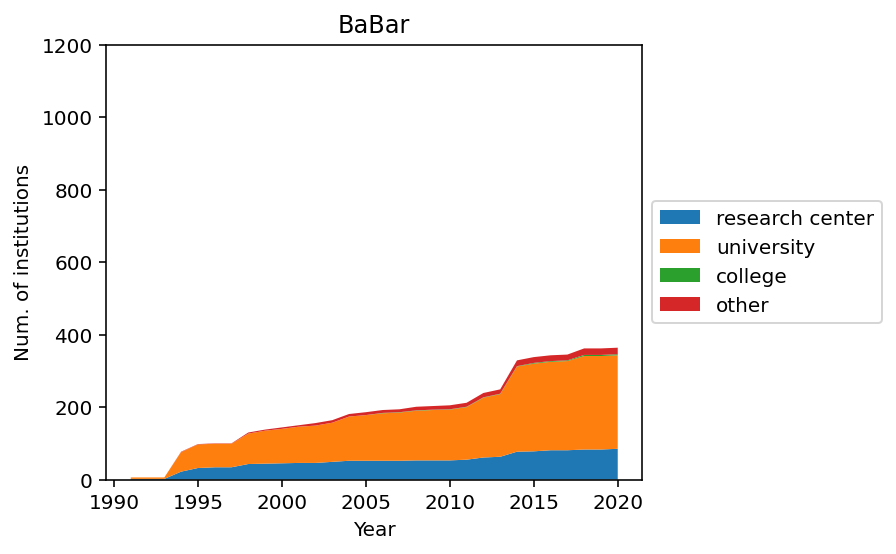

Processing LIGO


  0%|          | 0/1404481 [00:00<?, ?it/s]

  0%|          | 0/90563 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]

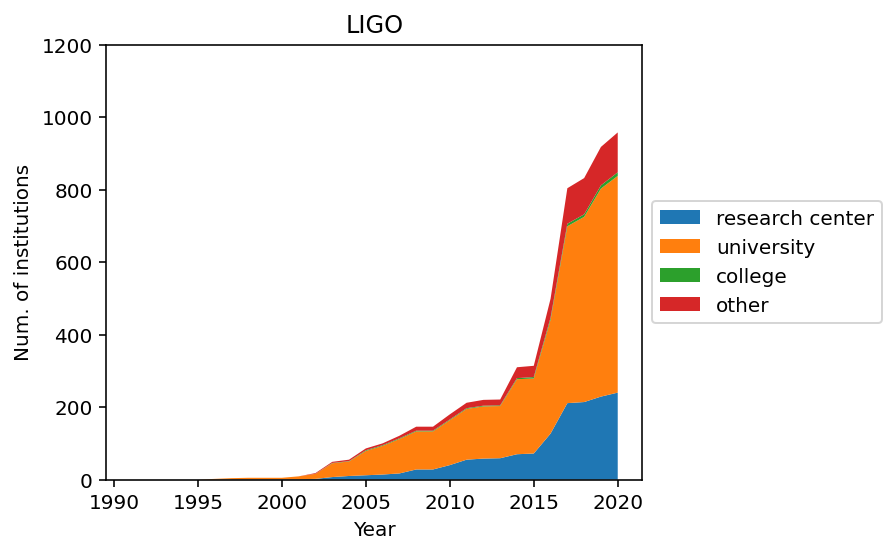

Processing ATLAS


  0%|          | 0/1404481 [00:00<?, ?it/s]

  0%|          | 0/90563 [00:00<?, ?it/s]

  0%|          | 0/14878 [00:00<?, ?it/s]

  0%|          | 0/14878 [00:00<?, ?it/s]

  0%|          | 0/14878 [00:00<?, ?it/s]

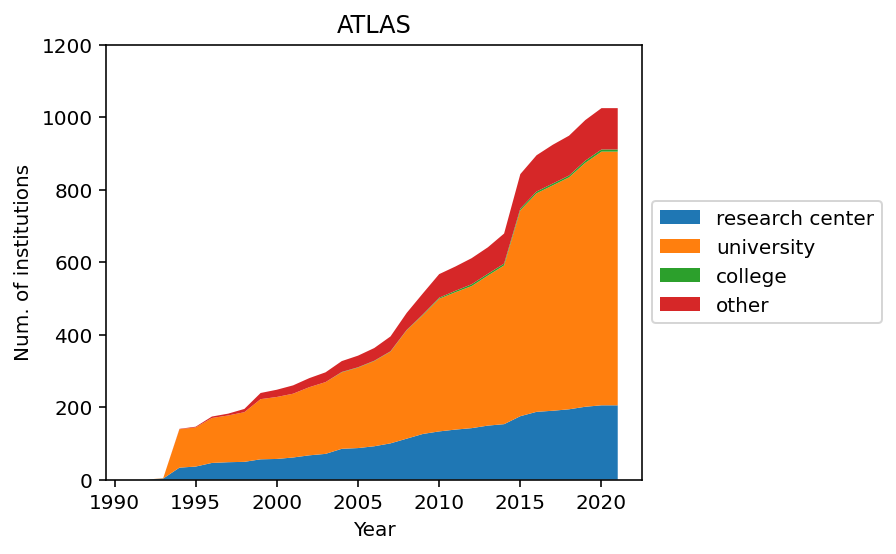

Processing IceCube


  0%|          | 0/1404481 [00:00<?, ?it/s]

  0%|          | 0/90563 [00:00<?, ?it/s]

  0%|          | 0/1099 [00:00<?, ?it/s]

  0%|          | 0/1099 [00:00<?, ?it/s]

  0%|          | 0/1099 [00:00<?, ?it/s]

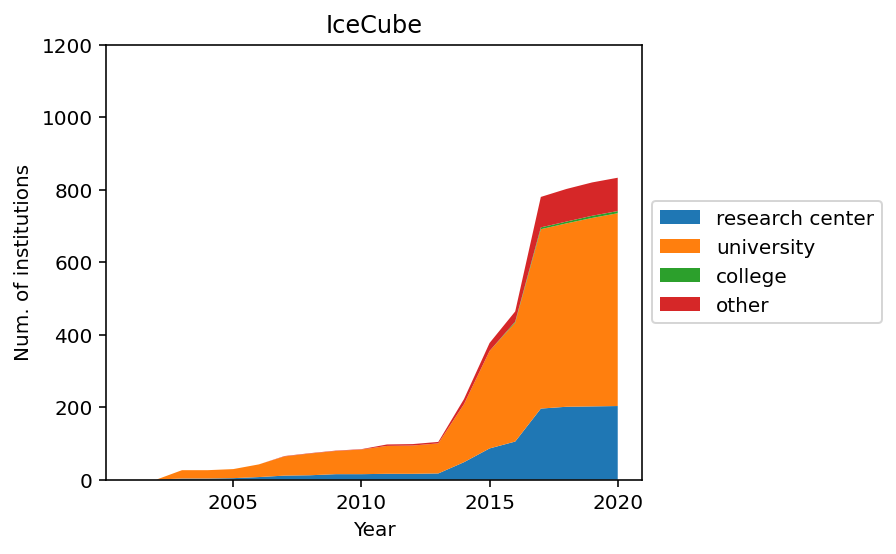

In [511]:

from collections import Counter
# collaborationWords = ["virgo","ligo"]
collaborationWordsSets = {
  "BaBar":"babar+babar collaborarion",
#   "Virgo-LIGO":"virgo+ligo+virgo scientific+ligo scientific+aligo+gbm-ligo+virgo ligo working group+ligo scientific+virgo joint ligo / working group+virgo ligo / working group+ligo+aligo",
#   "Virgo":"virgo+virgo scientific+virgo joint ligo / working group+virgo ligo / working group",
  "LIGO":"ligo+ligo scientific+aligo+gbm-ligo+virgo ligo working group+ligo scientific+virgo joint ligo / working group+virgo ligo / working group+ligo+aligo",
  "ATLAS":"atlas+atlas experiment",
  "IceCube":"icecube"
}

projectYears = {
  "BaBar":1990,
#   "Virgo-LIGO":1990,
  "Virgo":1990,
  "LIGO":1990,
  "ATLAS":1990,
  "IceCube":1990,
}

allowedInstitutions = {'research center', 'university', 'college'}

saveNetwork = True;

plotCategory = "Field"
HEPEntriesByCollaboration = {};
dataEntriesByCollaboration = {};
authorCountsByProject = {};
authorParticipatingCountsByProject = {};
authorAllTimeCountsByProject = {};
citationsPerYearByProject = {};
institutionsAllData = {}
for collaborationName,collaborationWords in collaborationWordsSets.items():
  print("Processing "+collaborationName)
  minYear = 0;
  finalYear = 0;
  collaborationExperiments = project2experiment[collaborationName];
  collaborationHEPEntries = [];
  citationsPerYear = Counter()
  citationsPerYearByProject[collaborationName] = citationsPerYear;
  for entry in tqdm(HEPEntries):
    if(entry["Collaborations"] is not None):
      foundWord = False;
#       collaborations = " ".join(entry["Collaborations"]).lower();
#       for word in collaborationWords.split("+"):
#           if(collaborations.find(word)>=0):
#             foundWord=True;
#             break;
      collaborationsSet = set({name.lower() for name in entry["Collaborations"]})
      if(len(collaborationsSet.intersection(collaborationWords.split("+")))):
        foundWord=True;
      if(foundWord):
        collaborationHEPEntries.append(entry);
    elif(entry["Experiment"] is not None):
      experiments = set(entry["Experiment"]);
      if(len(collaborationExperiments.intersection(experiments))>0):
        collaborationHEPEntries.append(entry);
        
  collaborationDataEntries = [];
  for entry in tqdm(dataEntries):
    if(entry["Collaborations"] is not None):
      foundWord = False;
#       collaborations = " ".join(entry["Collaborations"]).lower();
#       for word in collaborationName.split("+"):
#           if(collaborations.find(word)>=0):
#             foundWord=True;
#             break;
      collaborationsSet = set({name.lower() for name in entry["Collaborations"]})
      if(len(collaborationsSet.intersection(collaborationWords.split("+")))):
        foundWord=True;
      if(foundWord):
        collaborationDataEntries.append(entry);
    elif(entry["Experiment"] is not None):
      experiments = set(entry["Experiment"]);
      if(len(collaborationExperiments.intersection(experiments))>0):
        collaborationHEPEntries.append(entry);

  HEPEntriesByCollaboration[collaborationName] = collaborationHEPEntries;
  dataEntriesByCollaboration[collaborationName] = collaborationDataEntries;
  institutionsLists = [];
  authorsLists = [];
  collaborationYears = [];
  for entry in tqdm(collaborationHEPEntries):
    authors = [];
    if "FirstAuthor" in entry and entry["FirstAuthor"] is not None:
        authors += [entry["FirstAuthor"]];

    if "Authors" in entry and entry["Authors"] is not None:
        authors += entry["Authors"];

    institutionIDs = [int(author["Institution ID"]) for author in authors if "Institution ID" in author and author["Institution ID"] is not None]
    authorIDs = [int(author["ID"]) for author in authors if "ID" in author and author["ID"] is not None]
    institutionsLists.append(institutionIDs);
    authorsLists.append(authorIDs);
    collaborationYears.append(entry["Year"]);
  
  minYear = min([year for year in collaborationYears if year is not None]);
  
  if(projectYears[collaborationName]>minYear):
    minYear = projectYears[collaborationName];

  if(finalYear==0):
    finalYear = max([year for year in collaborationYears if year is not None]);

  institutionsDict = {int(entry["ID"]):entry for entry in institutionsEntries}

  indexToInstitution = [];
  institutionToIndex = {};
  for entry in tqdm(institutionsLists):
    for institution in set(entry):
      if(institution not in institutionToIndex):
        institutionToIndex[institution] = len(institutionToIndex);
        indexToInstitution.append(institution)

  
  from itertools import combinations
  edgesWeights = {}
  
  

  
  plotAuthorsByYear = {};
  participatingAuthorsByYear = {};
  for i in tqdm(range(len(institutionsLists))):
    entry = institutionsLists[i];
    institutionsIDs = set(entry) # use set for 1 weight per article
    authorEntry = authorsLists[i];
    authorsIDs = set(authorEntry) # use set for 1 weight per article
    institutionsEdges = combinations(institutionsIDs,2);
    year = collaborationYears[i];
    if(year not in plotAuthorsByYear):
      plotAuthorsByYear[year] = set();
      participatingAuthorsByYear[year] = set();
    plotAuthorsByYear[year].update(authorsIDs);
    participatingAuthorsByYear[year] = set(authorsIDs);
    for fromVertex,toVertex in institutionsEdges:
      if(fromVertex!=toVertex):
        edge = min(fromVertex,toVertex),max(fromVertex,toVertex),year;
        if(edge not in edgesWeights):
          edgesWeights[edge] = 0.0;
        edgesWeights[edge]+=1.0/len(institutionsIDs);
    
  plotAuthorsYears = [];
  plotParticipatingAuthorsCount = [];
  plotCumulativeAuthorsCount = [];
  plotAllTimeAuthorsCount = [];
  
  allAuthorsSet = set();
  participatingAuthorsSet = set()
  allTimeAuthorsSet = set()
  
  plotDictionary = {(entry["Field"].lower() if (entry["Field"] is not None and entry["Field"].lower() in allowedInstitutions) else "other"):[] for entry in institutionsEntries}
  for maxYear in range(minYear+1,finalYear+1):
    import igraph as ig
    import xnetwork as xn
    
    plotAuthorsYears.append(maxYear);
    if(maxYear in plotAuthorsByYear):
      allAuthorsSet = (plotAuthorsByYear[maxYear]);
      participatingAuthorsSet = (participatingAuthorsByYear[maxYear]);
      allTimeAuthorsSet.update(allAuthorsSet)
    plotCumulativeAuthorsCount.append(len(allAuthorsSet));
    plotParticipatingAuthorsCount.append(len(participatingAuthorsSet));
    plotAllTimeAuthorsCount.append(len(allTimeAuthorsSet));
    edges = [(institutionToIndex[key[0]],institutionToIndex[key[1]]) for key in edgesWeights]
    edgesYears = [key[2] for key in edgesWeights]
    weights = [edgesWeights[key] for key in edgesWeights]
    
    g = ig.Graph(len(institutionToIndex),edges=edges,directed=False,edge_attrs={"weight":weights,"year":edgesYears});
    g.vs["ID"] = [indexToInstitution[i] for i in range(g.vcount())];
    g.vs["Name"] = [institutionsDict[aID]["Name"] for aID in g.vs["ID"]]
    g.vs["Field"] = [institutionsDict[aID]["Field"].lower() if institutionsDict[aID]["Field"] is not None else "None" for aID in g.vs["ID"]]
    countries = [];
    for aID in g.vs["ID"]:
      country = "None";
      if(institutionsDict[aID]["Address"] is not None and "Country" in institutionsDict[aID]["Address"]):
        country = institutionsDict[aID]["Address"]["Country"].lower();
      countries.append(country)
    g.vs["Country"] = countries;
    
    countriesCodes = [];
    for aID in g.vs["ID"]:
      countryCode = "None";
      if(institutionsDict[aID]["Address"] is not None and "CountryCode" in institutionsDict[aID]["Address"]):
        countryCode = institutionsDict[aID]["Address"]["CountryCode"].upper();
      countriesCodes.append(countryCode);
    g.vs["CountryCode"] = countriesCodes;

    geolocations = [];
    for aID in g.vs["ID"]:
      geolocation = (0.0,0.0);
      geoDict = institutionsDict[aID]["Geolocation"];
      if(geoDict is not None and "Lon" in geoDict and "Lat" in geoDict):
        geolocation = float(geoDict["Lon"]),float(geoDict["Lat"]);
      geolocations.append(geolocation);
    g.vs["Position"] = geolocations;
    
    # g.vs["CountryCode"] = [(institutionsDict[aID]["Address"]["CountryCode"] if "CountryCode" in institutionsDict[aID]["Address"] else None) for aID in g.vs["ID"]]

    edgesToDelete = [];
    for i,edge in enumerate(g.es):
      if(edge["year"] is None or edge["year"]<minYear or edge["year"]>maxYear):
        edgesToDelete.append(i);

    g.delete_edges(edgesToDelete);


    gsimple = g.simplify(combine_edges={"weight":"sum","year":"min"});
    gsimple.es["weight"] = np.log(np.array(gsimple.es["weight"])+1);
    ggiant = gsimple.clusters().giant();
  #   if(ggiant.ecount()>0):
  #     xn.igraph2xnet(ggiant,"../Data/Networks/network_%s_%d_%d.xnet"%(collaborationName,minYear,maxYear));
    
    verticesToDelete = [];
    degrees= gsimple.degree()
    for i,vertex in enumerate(gsimple.vs):
      if(vertex["Position"] == (0.0,0.0)):
        verticesToDelete.append(i);
      if(degrees[i]==0):
        verticesToDelete.append(i);
    gsimple.delete_vertices(verticesToDelete);
  #   ggiant = gsimple.clusters().giant();
    histData = Counter([(entry.lower() if (entry is not None and entry.lower() in allowedInstitutions) else "other") for entry in g.vs["Field"]])
    for key in plotDictionary:
      if(key in histData):
        plotDictionary[key].append(histData[key]);
      else:
        plotDictionary[key].append(0);
    if(gsimple.ecount()>0 and saveNetwork):
      xn.igraph2xnet(gsimple,"../Data/Networks/network_%s_%d_%d_geo.xnet"%(collaborationName,minYear,maxYear));
  
  authorCountsByProject[collaborationName] = (plotAuthorsYears,plotCumulativeAuthorsCount);
  authorAllTimeCountsByProject[collaborationName] = (plotAuthorsYears,plotAllTimeAuthorsCount);
  authorParticipatingCountsByProject[collaborationName] = (plotAuthorsYears,plotParticipatingAuthorsCount);
  institutionsAllData[collaborationName] = (range(minYear+1,finalYear+1),plotDictionary.values(),plotDictionary.keys())
  fig = plt.figure()
  ax = plt.subplot(111)
  
  ax.stackplot(range(minYear+1,finalYear+1),plotDictionary.values(),labels=plotDictionary.keys());

  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

  # Put a legend to the right of the current axis
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  ax.set_title(collaborationName)
  ax.set_xlabel("Year")
  ax.set_ylabel("Num. of institutions")
  plt.ylim(0,1200)
  plt.savefig("../Figures/institutions_%s.pdf"%collaborationName)
  plt.show()


BaBar 364
LIGO 958
ATLAS 1025
IceCube 833


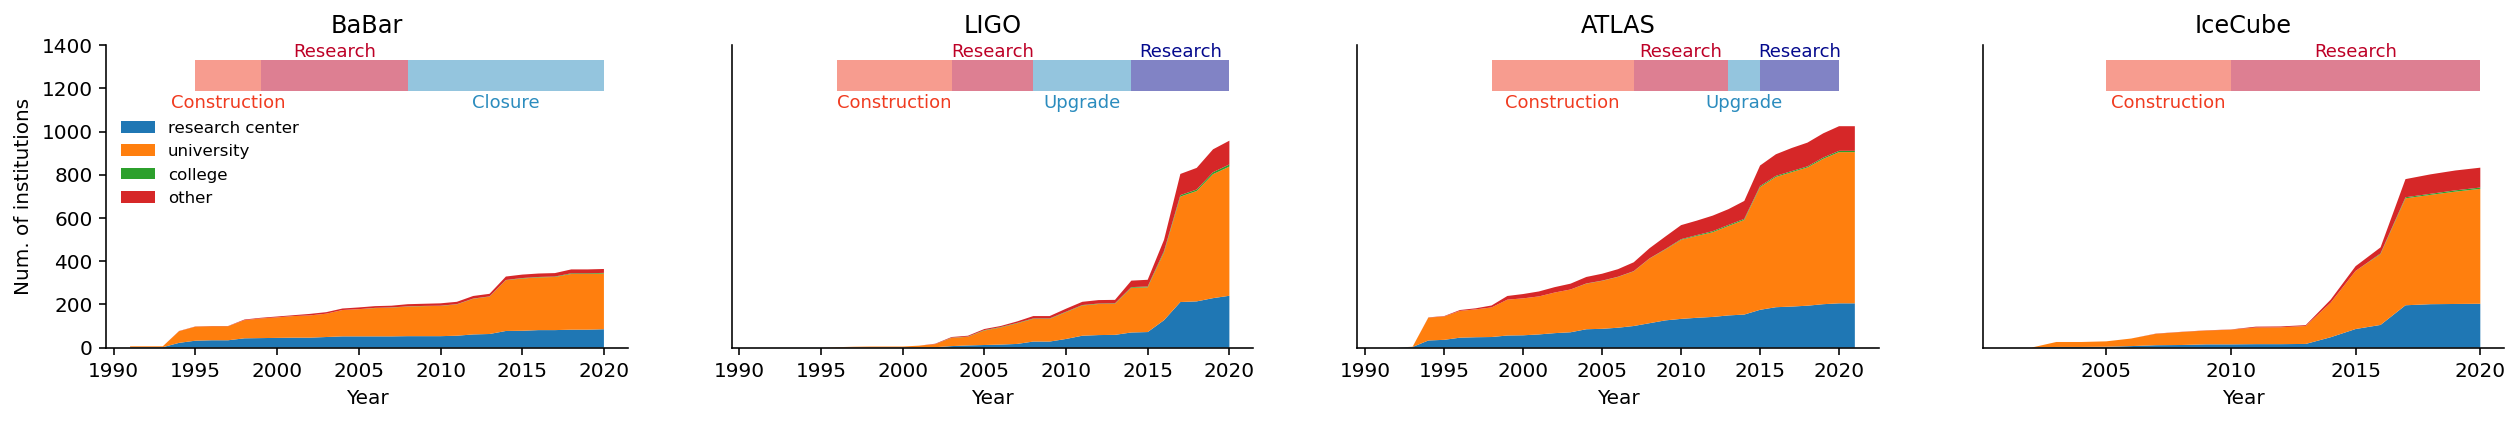

In [130]:
#TO GENERATE JSON
consideredCollaborations = ["BaBar","LIGO","ATLAS","IceCube"]

stageColors = [
  np.array([240,59,32])/255.0,
  np.array([189,0,38])/255.0,
  np.array([43,140,190])/255.0,
  np.array([4,9,141])/255.0,
]


projectStages = {
  "BaBar":[
    ("Construction",(1995,1999)),
    ("Research",(1999,2008)),
    ("Closure",(2008,2020))
  ],
  "Virgo-LIGO":1990,
  "Virgo":[
    ("Construction",(1996,2003)),
    ("Research",(2003,2011)),
    ("Upgrade",(2011,2017)),
    ("Research",(2017,2020)),
  ],
  "LIGO":[
    ("Construction",(1996,2003)),
    ("Research",(2003,2008)),
    ("Upgrade",(2008,2014)),
    ("Research",(2014,2020)),
  ],
  "ATLAS":[
    ("Construction",(1998,2007)),
    ("Research",(2007,2013)),
    ("Upgrade",(2013,2015)),
    ("Research",(2015,2020)),
  ],
  "IceCube":[
    ("Construction",(2005,2010)),
    ("Research",(2010,2020)),
  ]
}


# 
fig = plt.figure(figsize=(len(consideredCollaborations)*4.5,2.8))

affiliationsByProject = {}
for plotIndex,collaborationName in enumerate(consideredCollaborations):
  ax = plt.subplot(1,len(consideredCollaborations),1+plotIndex)
  stages = projectStages[collaborationName];
  for stageIndex,(stageName,(stageStart,stageEnd)) in enumerate(stages):
    ax.axvspan(stageStart, stageEnd, color=stageColors[stageIndex], alpha=0.5,
               lw=0,ymin=0.85,ymax=0.95)
    if(stageIndex%2==0):
      textPosition = 0.84
      textAlign = "top"
    else:
      textPosition = 0.95
      textAlign = "bottom"
    ax.text((stageStart+stageEnd)/2.0,
            textPosition, stageName,
            color=stageColors[stageIndex],
            horizontalalignment='center',verticalalignment=textAlign,
            fontsize=9,
            transform=ax.get_xaxis_transform())
 
  yearsData,institutionSeries,institutionsLabels=institutionsAllData[collaborationName]
  ax.stackplot(yearsData,institutionSeries,labels=institutionsLabels);
  print("%s %d"%(collaborationName,np.sum(list(institutionSeries),0)[-1]))
  # box = ax.get_position()
  # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  affiliationsByProject[collaborationName] = [list(yearsData),np.sum(list(institutionSeries),0).tolist()]
  # # Put a legend to the right of the current axis
  # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  ax.set_title(collaborationName)
  ax.set_xlabel("Year")
  if(plotIndex==0):
    ax.set_ylabel("Num. of institutions")
    ax.legend(loc='upper left',fontsize="small",frameon=False, bbox_to_anchor=(0.0,0.8))
  else:
    ax.set_yticks([])
  plt.ylim(0,1400)
  if(plotIndex==len(consideredCollaborations)-1):
#     ax.legend(loc='upper left',fontsize="x-small",frameon=False)
    pass;
    
  
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.subplots_adjust(wspace=0.20,bottom=0.15,left=0.05,right=0.975,top=0.90)

# plt.tight_layout()
plt.savefig("../Figures/institutions_All.pdf")
plt.show()

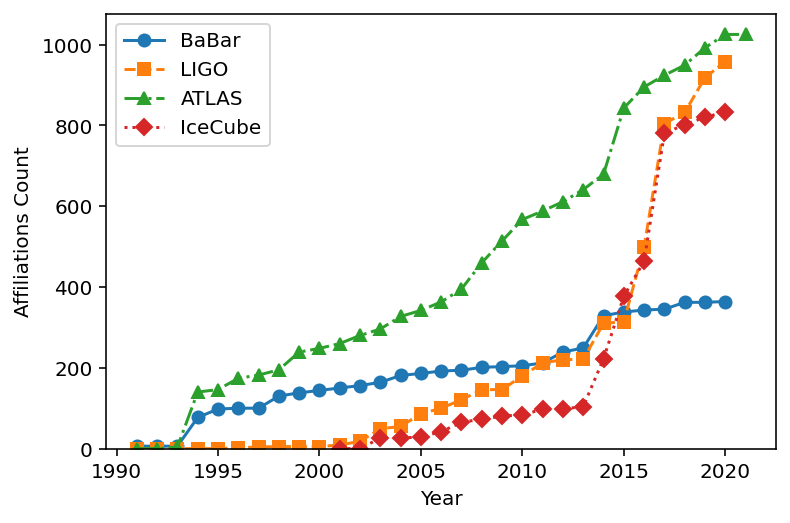

In [183]:
#Total Affiliations Over time.
minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,affiliationsCount)) in enumerate(affiliationsByProject.items()):
    ax.plot(years,affiliationsCount,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Affiliations Count")
# plt.savefig("../../Figures/BioMedAuthorsTotal_v2.pdf")
plt.show()
with open("../Data/PlotData/Physics_totalAffiliationsData.json","wt") as fd:
    ujson.dump(affiliationsByProject,fd)

In [514]:
# Calculating citations per year
citationsPerYearByProject = {};
for collaborationName,entries in HEPEntriesByCollaboration.items():
  citationsPerYear = Counter()
  citationsPerYearByProject[collaborationName] = citationsPerYear
  for entry in entries:
    if("ID" in entry):
      entryID = int(entry["ID"])
      if(entryID in ID2citations):
        citationsPerYear.update([year for reference,year in ID2citations[entryID]]);


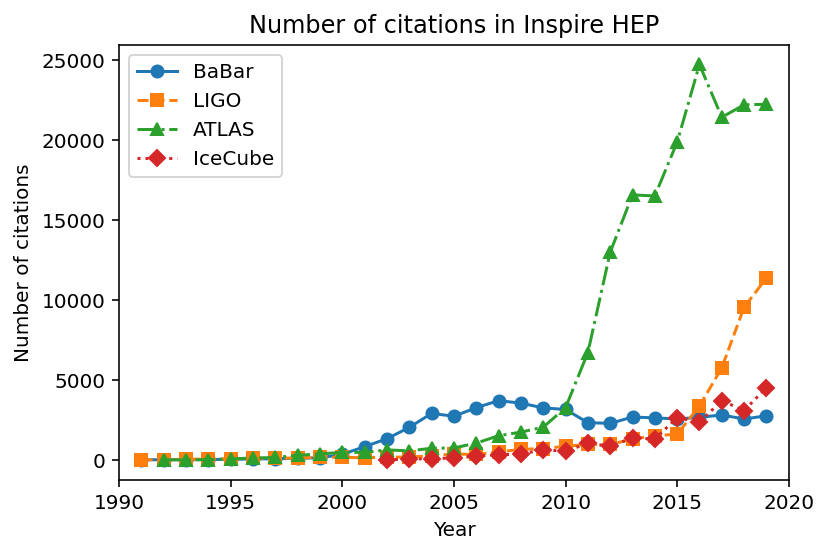

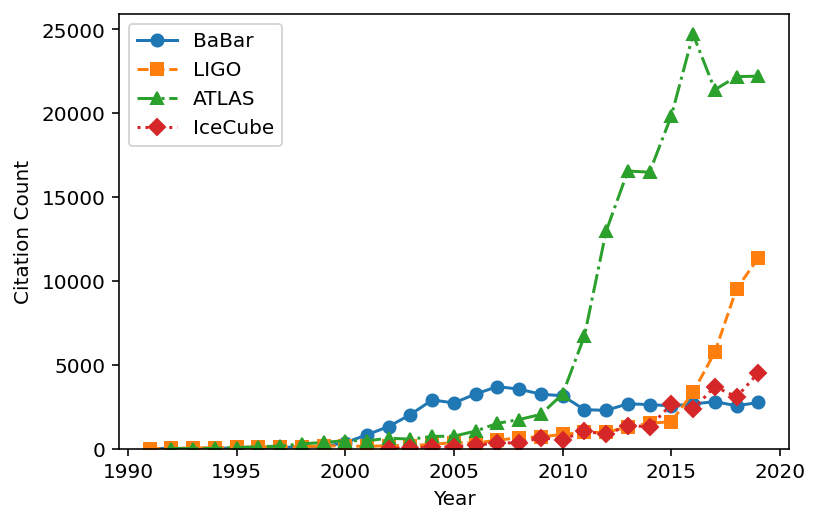

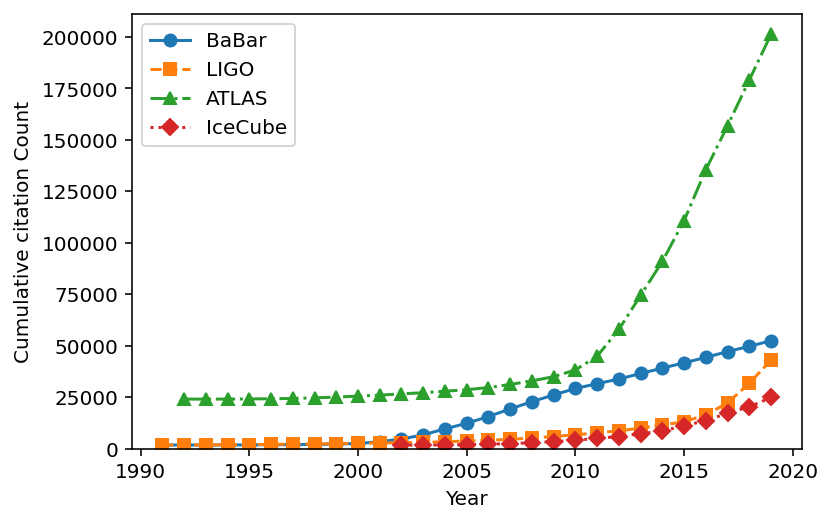

In [188]:
#Saving citation data
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
fig = plt.figure()
ax = plt.subplot(111)

# collaborationName = "IceCube"

citationsByProject = {}
cumulativeCitationsByProject = {}
for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  projectCitations = citationsPerYearByProject[collaborationName]
  years = []
  citations = []
  cumulativeCitations = []
  allCitations = 0;
  startYear = 1990
  for year in sorted(projectCitations.keys()):
    allCitations+=projectCitations[year];
    if year>=startYear and year<2020:
      years.append(year);
      citations.append(projectCitations[year])
      cumulativeCitations.append(allCitations)
  citationsByProject[collaborationName] = [years,citations]
  cumulativeCitationsByProject[collaborationName] = [years,cumulativeCitations]
  ax.plot(years,citations,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend()
# Put a legend to the right of the current axis
ax.set_title("Number of citations in Inspire HEP")
ax.set_xlabel("Year")
ax.set_ylabel("Number of citations")
ax.set_xlim(startYear,2020)
# ax.set_yscale("log")
plt.savefig("../Figures/yearlyCitations.pdf")
plt.show()


minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,citationsCount)) in enumerate(citationsByProject.items()):
    ax.plot(years,citationsCount,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Citation Count")
# plt.savefig("../../Figures/BioMedAuthorsTotal_v2.pdf")
plt.show()



minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,cumulativeCitationsCount)) in enumerate(cumulativeCitationsByProject.items()):
    ax.plot(years,cumulativeCitationsCount,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative citation Count")
# plt.savefig("../../Figures/BioMedAuthorsTotal_v2.pdf")
plt.show()
with open("../Data/PlotData/Physics_citationsData.json","wt") as fd:
  ujson.dump(citationsByProject,fd)
with open("../Data/PlotData/Physics_cumulativeCitationsData.json","wt") as fd:
  ujson.dump(cumulativeCitationsByProject,fd)

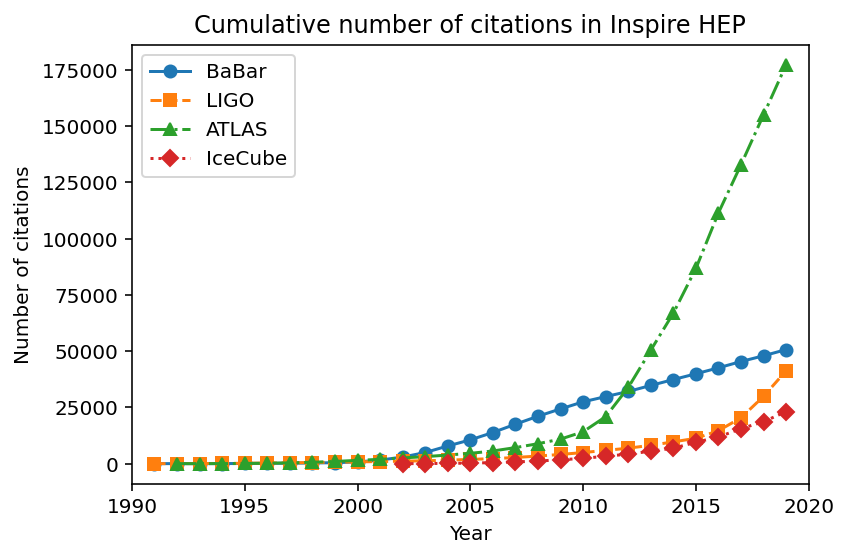

In [17]:
fig = plt.figure()
ax = plt.subplot(111)

# collaborationName = "IceCube"
cumulativeCitationsPerProject = {}
for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  (years,citations) = citationsAndYearsByProject[collaborationName]
  cumulativeCitations = np.cumsum(citations)
  cumulativeCitationsPerProject[collaborationName] = (years,cumulativeCitations)
  ax.plot(years,cumulativeCitations,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend()
# Put a legend to the right of the current axis
ax.set_title("Cumulative number of citations in Inspire HEP")
ax.set_xlabel("Year")
ax.set_ylabel("Number of citations")
ax.set_xlim(startYear,2020)
plt.tight_layout()
plt.savefig("../Figures/yearlyCumulativeCitations.pdf")
plt.show()

In [18]:
#Total number of citations
for name,(year,cumualtiveCitations) in cumulativeCitationsPerProject.items():
  print("%s: %d"%(name,cumualtiveCitations[-1]))

BaBar: 50687
LIGO: 41287
ATLAS: 177233
IceCube: 23155


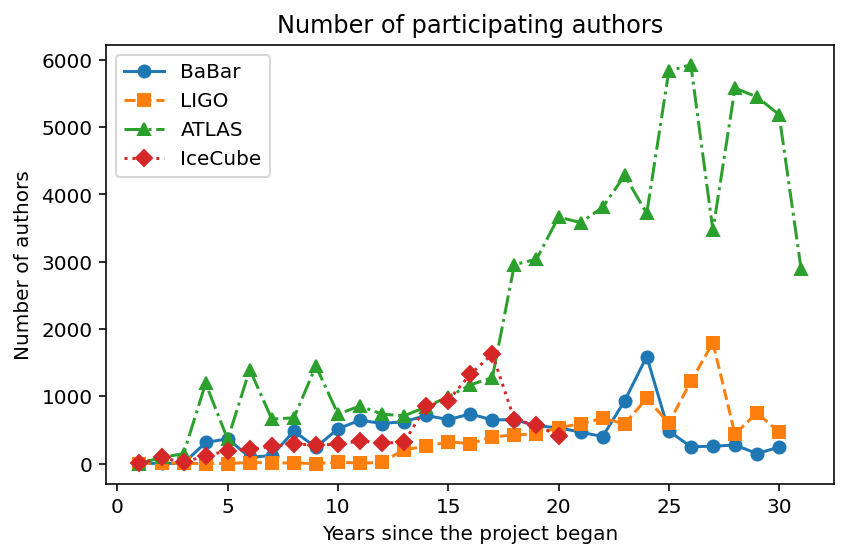

In [189]:
#Calculating the number of participating authors

fig = plt.figure()
ax = plt.subplot(111)

for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  plotAuthorsYears,plotPaticipatingAuthorsCount = authorCountsByProject[collaborationName];
  ax.plot(range(1,len(plotPaticipatingAuthorsCount)+1),plotPaticipatingAuthorsCount,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);
  
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Put a legend to the right of the current axis
ax.set_title("Number of participating authors")
ax.set_xlabel("Years since the project began")
ax.set_ylabel("Number of authors")
plt.tight_layout()
plt.savefig("../Figures/participatingAuthorsSinceStart.pdf")
plt.show()



minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,authorCounts)) in enumerate(authorCountsByProject.items()):
    ax.plot(years,authorCounts,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Authors Count")
# plt.savefig("../../Figures/BioMedAuthorsTotal_v2.pdf")
plt.show()

with open("../Data/PlotData/Physics_AuthorsData.json","wt") as fd:
  ujson.dump(authorCountsByProject,fd)

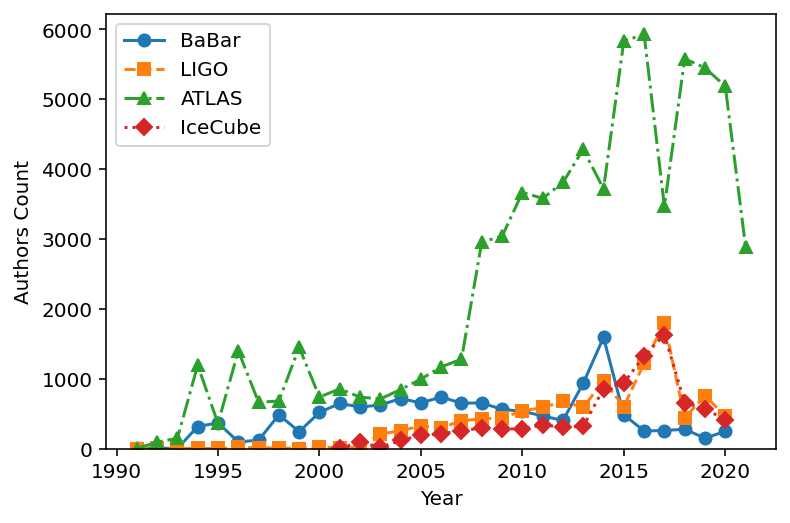

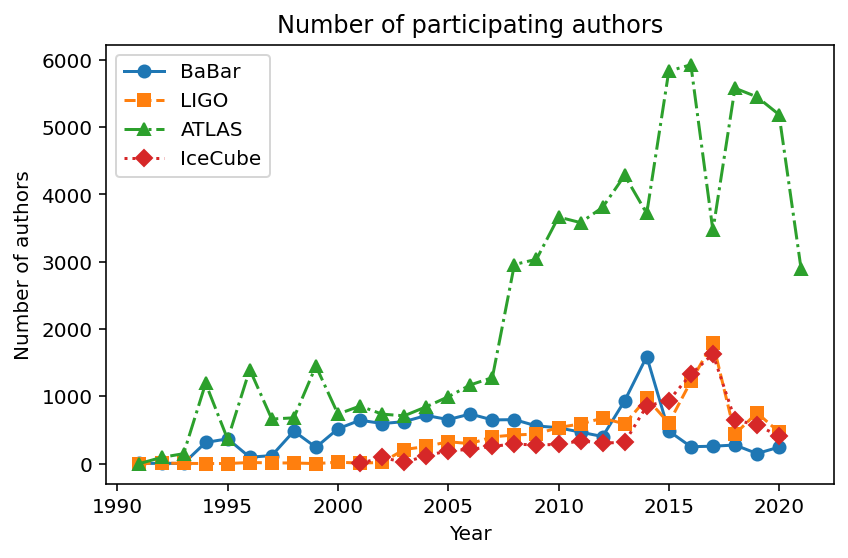

In [20]:
fig = plt.figure()
ax = plt.subplot(111)

for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  plotAuthorsYears,plotPaticipatingAuthorsCount = authorCountsByProject[collaborationName];
  ax.plot(plotAuthorsYears,plotPaticipatingAuthorsCount,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);
  
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Put a legend to the right of the current axis
ax.set_title("Number of participating authors")
ax.set_xlabel("Year")
ax.set_ylabel("Number of authors")
plt.tight_layout()
plt.savefig("../Figures/participatingAuthors.pdf")
plt.show()




BaBar: 2212
LIGO: 3081
ATLAS: 10493
IceCube: 2907


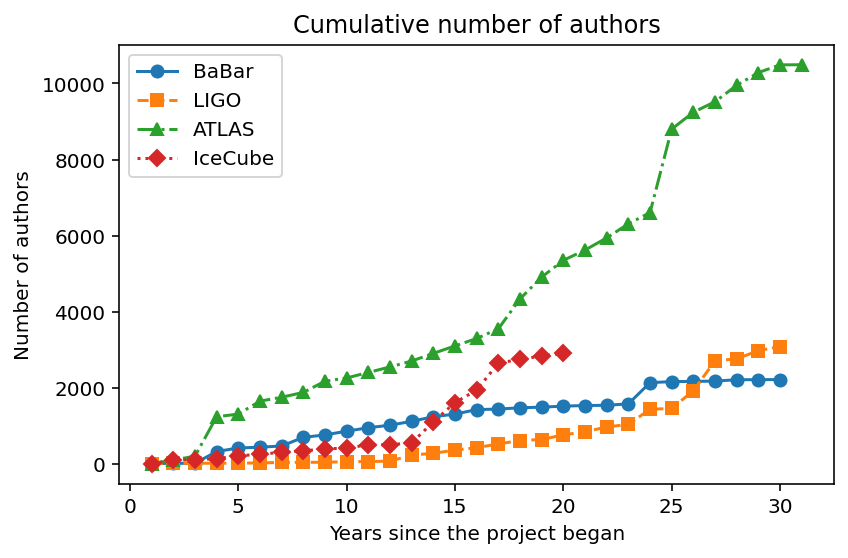

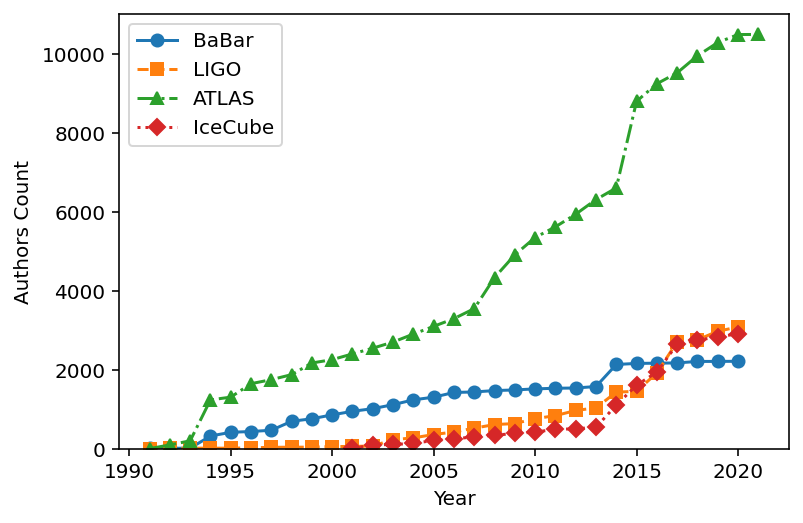

In [191]:
fig = plt.figure()
ax = plt.subplot(111)

for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  plotAuthorsYears,plotAllTimeAuthorsCount = authorAllTimeCountsByProject[collaborationName];
  ax.plot(range(1,len(plotAllTimeAuthorsCount)+1),plotAllTimeAuthorsCount,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);
  print("%s: %d"%(collaborationName,plotAllTimeAuthorsCount[-1]))
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Put a legend to the right of the current axis
ax.set_title("Cumulative number of authors")
ax.set_xlabel("Years since the project began")
ax.set_ylabel("Number of authors")
plt.tight_layout()
plt.savefig("../Figures/cumulativeAuthorsSinceStart.pdf")
plt.show()


minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,authorCounts)) in enumerate(authorAllTimeCountsByProject.items()):
    ax.plot(years,authorCounts,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Authors Count")
# plt.savefig("../../Figures/BioMedAuthorsTotal_v2.pdf")
plt.show()

with open("../Data/PlotData/Physics_TotalAuthorsData.json","wt") as fd:
  ujson.dump(authorAllTimeCountsByProject,fd)

BaBar: 2212
LIGO: 3081
ATLAS: 10493
IceCube: 2907


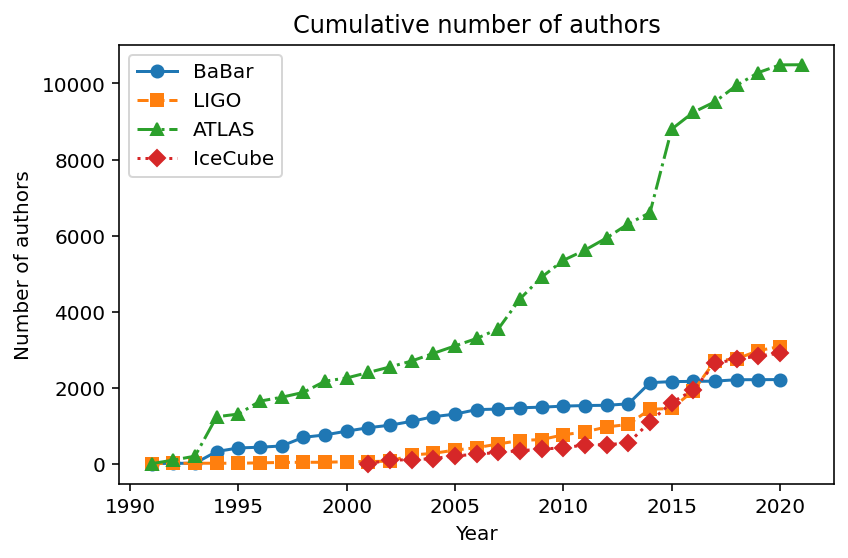

In [22]:
fig = plt.figure()
ax = plt.subplot(111)

for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  plotAuthorsYears,plotAllTimeAuthorsCount = authorAllTimeCountsByProject[collaborationName];
  ax.plot(plotAuthorsYears,plotAllTimeAuthorsCount,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);
  print("%s: %d"%(collaborationName,plotAllTimeAuthorsCount[-1]))
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Put a legend to the right of the current axis
ax.set_title("Cumulative number of authors")
ax.set_xlabel("Year")
ax.set_ylabel("Number of authors")
plt.tight_layout()
plt.savefig("../Figures/cumulativeAuthors.pdf")
plt.show()

In [513]:
# normalizing type and adding data to HEPEntries
HEPID2Index = {entry["ID"]:i for i,entry in enumerate(HEPEntries)}

for entry in tqdm(HEPEntries):
  if(entry["Type"] is not None):
    entry["Type"]=set([a.lower() for a in entry["Type"]])
    
for entry in tqdm(dataEntries):
  mainPublicationID = entry['MainPublication']
  if(mainPublicationID is not None):
    if(mainPublicationID in HEPID2Index):
      publicationIndex = HEPID2Index[mainPublicationID];
      if(HEPEntries[publicationIndex]["Type"] is not None):
        HEPEntries[publicationIndex]["Type"].add("data");
      else:
        HEPEntries[publicationIndex]["Type"] = set("data");

  0%|          | 0/1404481 [00:00<?, ?it/s]

  0%|          | 0/90563 [00:00<?, ?it/s]

In [29]:
#Counting each entry
for name in HEPEntriesByCollaboration:
  types = []
  for entry in tqdm(HEPEntriesByCollaboration[name]):
    if(entry is not None):
      types+=([a.lower() for a in entry["Type"]])
  print(name)
  print(Counter(types))

  0%|          | 0/2680 [00:00<?, ?it/s]

BaBar
Counter({'hep': 2680, 'core': 2216, 'citeable': 1906, 'conferencepaper': 1554, 'arxiv': 1092, 'published': 808, 'thesis': 363, 'review': 57, 'data': 26, 'introductory': 7, 'report': 4, 'fermilab': 4, 'proceedings': 2, 'book': 2, 'lectures': 2, 'note': 1})


  0%|          | 0/564 [00:00<?, ?it/s]

LIGO
Counter({'hep': 564, 'citeable': 507, 'core': 495, 'published': 353, 'arxiv': 256, 'conferencepaper': 234, 'thesis': 18, 'fermilab': 15, 'review': 8, 'introductory': 2, 'lectures': 1, 'data': 1, 'bookchapter': 1})


  0%|          | 0/14878 [00:00<?, ?it/s]

ATLAS
Counter({'hep': 14878, 'core': 14205, 'citeable': 10515, 'conferencepaper': 7698, 'note': 4224, 'thesis': 2202, 'published': 2014, 'arxiv': 1562, 'data': 531, 'review': 96, 'fermilab': 65, 'report': 32, 'bookchapter': 21, 'introductory': 12, 'book': 10, 'lectures': 8, 'noncore': 7, 'proceedings': 5, 'withdrawn': 2})


  0%|          | 0/1099 [00:00<?, ?it/s]

IceCube
Counter({'hep': 1099, 'core': 955, 'citeable': 852, 'conferencepaper': 705, 'published': 265, 'arxiv': 253, 'thesis': 90, 'fermilab': 8, 'review': 7, 'proceedings': 2, 'introductory': 1, 'noncore': 1})


In [66]:
types = []
for name in HEPEntriesByCollaboration:
  for entry in tqdm(HEPEntriesByCollaboration[name]):
    if(entry is not None):
      types+=([a.lower() for a in entry["Type"]])
Counter(types)

  0%|          | 0/2680 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]

  0%|          | 0/14878 [00:00<?, ?it/s]

  0%|          | 0/1099 [00:00<?, ?it/s]

Counter({'conferencepaper': 10191,
         'hep': 19221,
         'core': 17871,
         'citeable': 13780,
         'review': 168,
         'report': 36,
         'published': 3440,
         'proceedings': 9,
         'introductory': 22,
         'arxiv': 3163,
         'thesis': 2673,
         'book': 12,
         'lectures': 11,
         'data': 558,
         'fermilab': 92,
         'note': 4225,
         'bookchapter': 22,
         'withdrawn': 2,
         'noncore': 8})

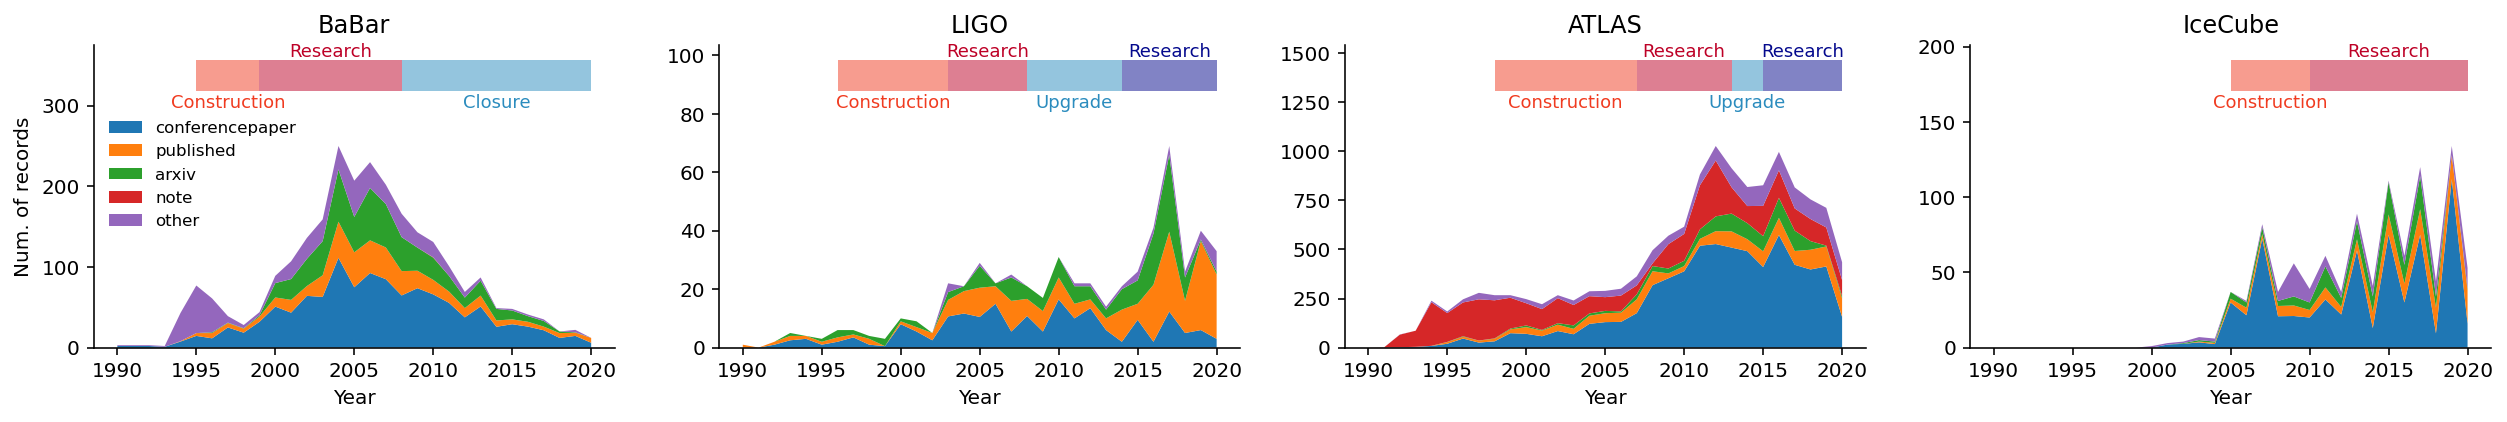

In [96]:
# Plotting output
minYear = 1990
from collections import OrderedDict
allowedTypes = OrderedDict([
('conferencepaper',0),
('published',0),
('arxiv',0),
# ('data',0),
# ('proceedings',0),
('note',0),
# ('review',0),
# ('book',0),
# ('citeable',0),
# ('hep',0),
# ('withdrawn',0),
# ('core',0),
# ('thesis',0),
# ('introductory',0),
# ('lectures',0),
# ('fermilab',0),
# ('bookchapter',0),
# ('activityreport',0),
# ('report',0),
# ('noncore',0),
# ('d0-preliminary-note',0),
]);


fig = plt.figure(figsize=(len(consideredCollaborations)*4.5,2.8))

for plotIndex,collaborationName in enumerate(consideredCollaborations):
  collaborationHEPEntries = HEPEntriesByCollaboration[collaborationName];
  
  collaborationYears = [entry["Year"] for entry in collaborationHEPEntries];

  if(minYear==0):
    minYear = min([year for year in collaborationYears if year is not None]);

  if(finalYear==0):
    finalYear = max([year for year in collaborationYears if year is not None]);

  plotDictionary = OrderedDict((typeName,[0]*(finalYear-minYear+1)) for typeName in allowedTypes)
  plotDictionary["other"] = [0]*(finalYear-minYear+1)
  
  totalsByYear = []
  for currentYear in range(minYear,finalYear+1):
    yearEntries = [entry for entry in collaborationHEPEntries if entry["Year"] is not None and entry["Year"]==currentYear]
    yearIndex = currentYear-minYear;
    yearTotal = 0
    for entry in yearEntries:
      if entry["Type"] is not None:
        sharedTypes = entry["Type"].intersection(allowedTypes);
        yearTotal+=1;
        if(sharedTypes):
#           for key in allowedTypes:
#             if(key in sharedTypes):
#               plotDictionary[key][yearIndex] += 1.0
#               break;
          weight = len(sharedTypes);
          for key in sharedTypes:
            plotDictionary[key][yearIndex] += 1.0/weight;
        else:
            plotDictionary["other"][yearIndex] += 1.0;
    totalsByYear.append(yearTotal); 
#   plotDictionary = 
#   fig = plt.figure()
#   ax = plt.subplot(111)
  
  ax = plt.subplot(1,len(consideredCollaborations),1+plotIndex)
  stages = projectStages[collaborationName];
  for stageIndex,(stageName,(stageStart,stageEnd)) in enumerate(stages):
    ax.axvspan(stageStart, stageEnd, color=stageColors[stageIndex], alpha=0.5,
               lw=0,ymin=0.85,ymax=0.95)
    if(stageIndex%2==0):
      textPosition = 0.84
      textAlign = "top"
    else:
      textPosition = 0.95
      textAlign = "bottom"
    ax.text((stageStart+stageEnd)/2.0,
            textPosition, stageName,
            color=stageColors[stageIndex],
            horizontalalignment='center',verticalalignment=textAlign,
            fontsize=9,
            transform=ax.get_xaxis_transform())
  
  ax.stackplot(range(minYear,finalYear+1),list(plotDictionary.values()),labels=list(plotDictionary.keys()))
  ax.set_title(collaborationName)
  ax.set_xlabel("Year")
  if(plotIndex==0):
    ax.set_ylabel("Num. of records")
    ax.legend(loc='upper left',fontsize="small",frameon=False, bbox_to_anchor=(0.0,0.8))
#   else:
#     ax.set_yticks([])
  plt.ylim(0,np.max(totalsByYear)*1.5)
  if(plotIndex==len(consideredCollaborations)-1):
#     ax.legend(loc='upper left',fontsize="x-small",frameon=False)
    pass;
    
  
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.subplots_adjust(wspace=0.20,bottom=0.15,left=0.05,right=0.975,top=0.90)
# plt.tight_layout()
plt.savefig("../Figures/output_All.pdf",pad_inches = 0)
plt.show()

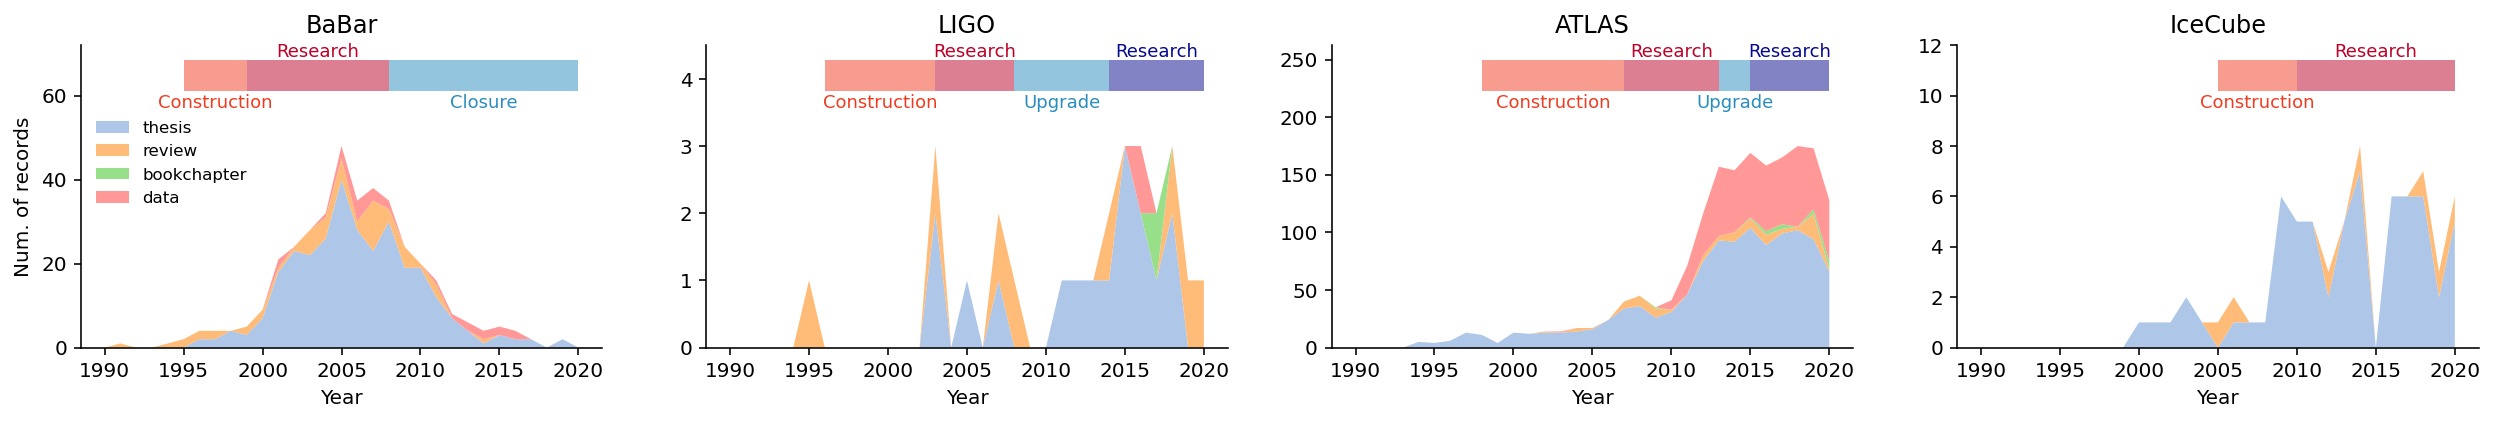

In [98]:
# Plotting other output

minYear=1990

otherColors = [
  "#aec7e8",
  "#ffbb78",
  "#98df8a",
  "#ff9896",
]
allowedTypes = OrderedDict([
# ('conferencepaper',0),
# ('arxiv',0),
# ('published',0),
# ('proceedings',0),
# ('note',0),
('thesis',0),
('review',0),
# ('book',0),
('bookchapter',0),
('data',0),
# ('activityreport',0),
# ('report',0),
# ('citeable',0),
# ('hep',0),
# ('withdrawn',0),
# ('core',0),
# ('introductory',0),
# ('lectures',0),
# ('fermilab',0),
# ('noncore',0),
# ('d0-preliminary-note',0),
]);


fig = plt.figure(figsize=(len(consideredCollaborations)*4.5,2.8))

for plotIndex,collaborationName in enumerate(consideredCollaborations):
  collaborationHEPEntries = HEPEntriesByCollaboration[collaborationName];
  
  collaborationYears = [entry["Year"] for entry in collaborationHEPEntries];

  if(minYear==0):
    minYear = min([year for year in collaborationYears if year is not None]);

  if(finalYear==0):
    finalYear = max([year for year in collaborationYears if year is not None]);

  plotDictionary = OrderedDict((typeName,[0]*(finalYear-minYear+1)) for typeName in allowedTypes)
#   plotDictionary["other"] = [0]*(finalYear-minYear+1)
  
  totalsByYear = []
  for currentYear in range(minYear,finalYear+1):
    yearEntries = [entry for entry in collaborationHEPEntries if entry["Year"] is not None and entry["Year"]==currentYear]
    yearIndex = currentYear-minYear;
    yearTotal=0
    for entry in yearEntries:
      if entry["Type"] is not None:
        sharedTypes = entry["Type"].intersection(allowedTypes);
        if(sharedTypes):
          weight = len(sharedTypes);
          for key in sharedTypes:
            plotDictionary[key][yearIndex] += 1.0/weight;
            yearTotal+=1
#         else:
#             plotDictionary["other"][yearIndex] += 1.0;

    totalsByYear.append(yearTotal); 
#   plotDictionary = 
#   fig = plt.figure()
#   ax = plt.subplot(111)
  
  ax = plt.subplot(1,len(consideredCollaborations),1+plotIndex)
  stages = projectStages[collaborationName];
  for stageIndex,(stageName,(stageStart,stageEnd)) in enumerate(stages):
    ax.axvspan(stageStart, stageEnd, color=stageColors[stageIndex], alpha=0.5,
               lw=0,ymin=0.85,ymax=0.95)
    if(stageIndex%2==0):
      textPosition = 0.84
      textAlign = "top"
    else:
      textPosition = 0.95
      textAlign = "bottom"
    ax.text((stageStart+stageEnd)/2.0,
            textPosition, stageName,
            color=stageColors[stageIndex],
            horizontalalignment='center',verticalalignment=textAlign,
            fontsize=9,
            transform=ax.get_xaxis_transform())
  
  ax.stackplot(range(minYear,finalYear+1),list(plotDictionary.values()),colors=otherColors,labels=list(plotDictionary.keys()))
  ax.set_title(collaborationName)
  ax.set_xlabel("Year")
  if(plotIndex==0):
    ax.set_ylabel("Num. of records")
    ax.legend(loc='upper left',fontsize="small",frameon=False, bbox_to_anchor=(0.0,0.8))
#   else:
#     ax.set_yticks([])
  plt.ylim(0,np.max(totalsByYear)*1.5)
  if(plotIndex==len(consideredCollaborations)-1):
#     ax.legend(loc='upper left',fontsize="x-small",frameon=False)
    pass;
    
  
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.subplots_adjust(wspace=0.20,bottom=0.15,left=0.05,right=0.975,top=0.90)
# plt.tight_layout()
plt.savefig("../Figures/output_Other_All.pdf")
plt.show()

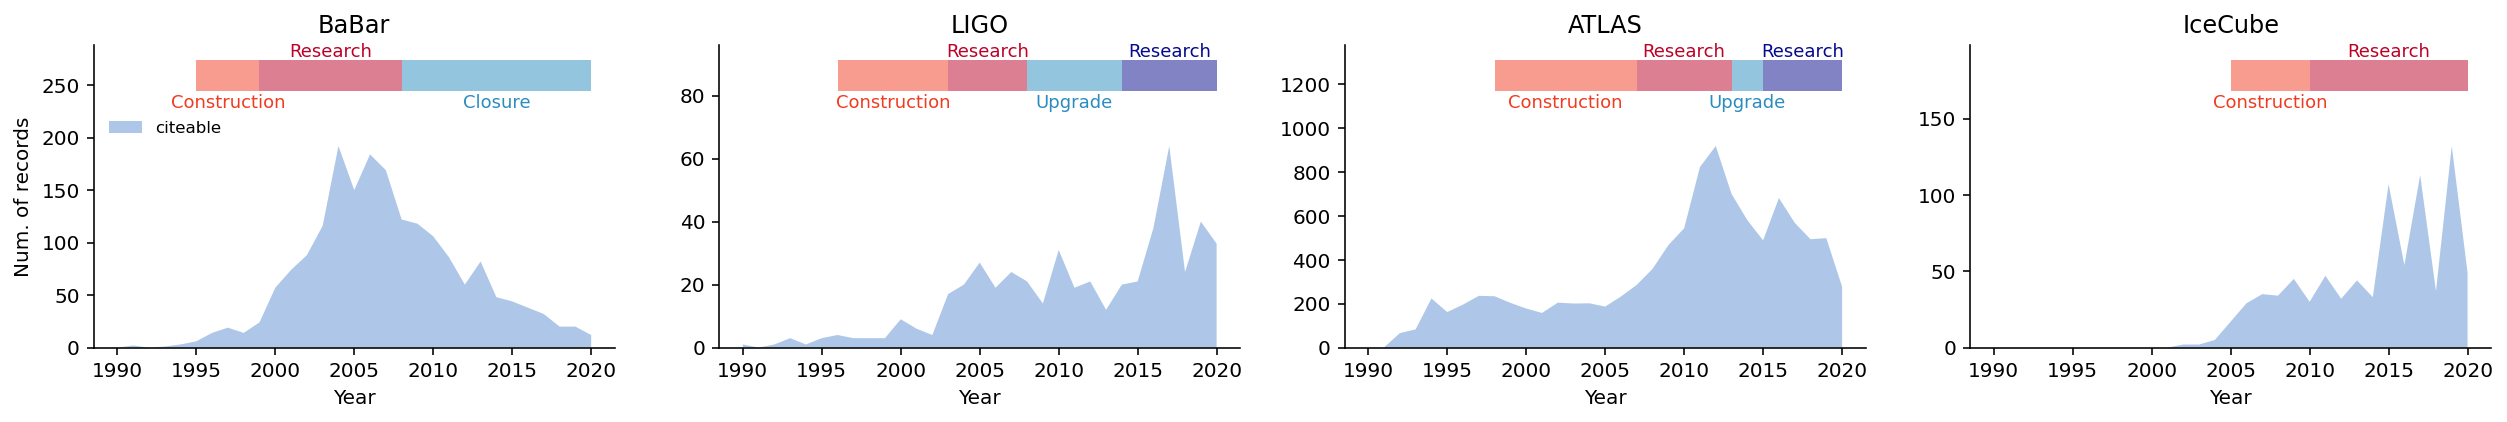

In [167]:
# Saving Citable only to JSON data
minYear=1990

otherColors = [
  "#aec7e8",
  "#ffbb78",
  "#98df8a",
  "#ff9896",
]
allowedTypes = OrderedDict([
# ('conferencepaper',0),
# ('arxiv',0),
# ('published',0),
# ('proceedings',0),
# ('note',0),
# ('thesis',0),
# ('review',0),
# ('book',0),
# ('bookchapter',0),
# ('data',0),
# ('activityreport',0),
# ('report',0),
('citeable',0),
# ('hep',0),
# ('withdrawn',0),
# ('core',0),
# ('introductory',0),
# ('lectures',0),
# ('fermilab',0),
# ('noncore',0),
# ('d0-preliminary-note',0),
]);

publicationsByProject = {}

fig = plt.figure(figsize=(len(consideredCollaborations)*4.5,2.8))

for plotIndex,collaborationName in enumerate(consideredCollaborations):
  collaborationHEPEntries = HEPEntriesByCollaboration[collaborationName];
  
  collaborationYears = [entry["Year"] for entry in collaborationHEPEntries];

  if(minYear==0):
    minYear = min([year for year in collaborationYears if year is not None]);

  if(finalYear==0):
    finalYear = max([year for year in collaborationYears if year is not None]);

  plotDictionary = OrderedDict((typeName,[0]*(finalYear-minYear+1)) for typeName in allowedTypes)
#   plotDictionary["other"] = [0]*(finalYear-minYear+1)
  
  totalsByYear = []
  years = []
  for currentYear in range(minYear,finalYear+1):
    yearEntries = [entry for entry in collaborationHEPEntries if entry["Year"] is not None and entry["Year"]==currentYear]
    yearIndex = currentYear-minYear;
    yearTotal=0
    for entry in yearEntries:
      if entry["Type"] is not None:
        sharedTypes = entry["Type"].intersection(allowedTypes);
        if(sharedTypes):
          weight = len(sharedTypes);
          for key in sharedTypes:
            plotDictionary[key][yearIndex] += 1.0/weight;
            yearTotal+=1
#         else:
#             plotDictionary["other"][yearIndex] += 1.0;

    totalsByYear.append(yearTotal); 
    years.append(currentYear)
  publicationsByProject[collaborationName] = [years,totalsByYear]
#   plotDictionary = 
#   fig = plt.figure()
#   ax = plt.subplot(111)
  
  ax = plt.subplot(1,len(consideredCollaborations),1+plotIndex)
  stages = projectStages[collaborationName];
  for stageIndex,(stageName,(stageStart,stageEnd)) in enumerate(stages):
    ax.axvspan(stageStart, stageEnd, color=stageColors[stageIndex], alpha=0.5,
               lw=0,ymin=0.85,ymax=0.95)
    if(stageIndex%2==0):
      textPosition = 0.84
      textAlign = "top"
    else:
      textPosition = 0.95
      textAlign = "bottom"
    ax.text((stageStart+stageEnd)/2.0,
            textPosition, stageName,
            color=stageColors[stageIndex],
            horizontalalignment='center',verticalalignment=textAlign,
            fontsize=9,
            transform=ax.get_xaxis_transform())
  
  ax.stackplot(range(minYear,finalYear+1),list(plotDictionary.values()),colors=otherColors,labels=list(plotDictionary.keys()))
  ax.set_title(collaborationName)
  ax.set_xlabel("Year")
  if(plotIndex==0):
    ax.set_ylabel("Num. of records")
    ax.legend(loc='upper left',fontsize="small",frameon=False, bbox_to_anchor=(0.0,0.8))
#   else:
#     ax.set_yticks([])
  
  plt.ylim(0,np.max(totalsByYear)*1.5)
  if(plotIndex==len(consideredCollaborations)-1):
#     ax.legend(loc='upper left',fontsize="x-small",frameon=False)
    pass;
    
  
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.subplots_adjust(wspace=0.20,bottom=0.15,left=0.05,right=0.975,top=0.90)
# plt.tight_layout()
# plt.savefig("../Figures/output_Other_All.pdf")
plt.show()

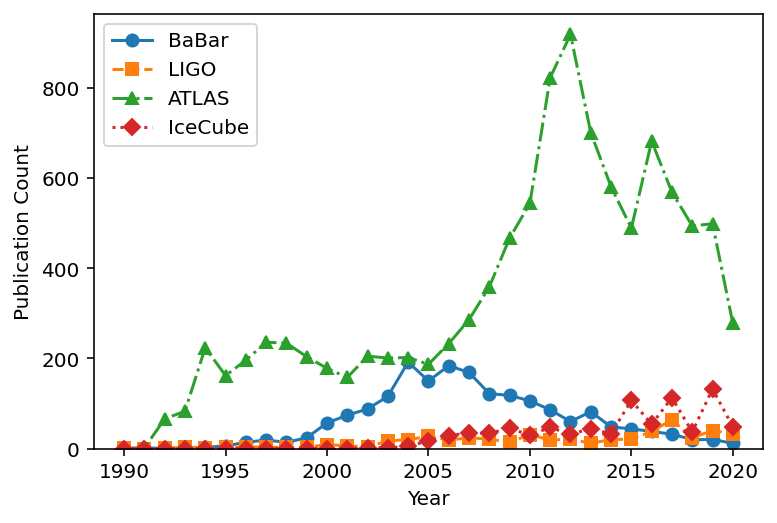

In [171]:
minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,publicationsCount)) in enumerate(publicationsByProject.items()):
    ax.plot(years,publicationsCount,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Publication Count")
# plt.savefig("../../Figures/BioMedAuthorsTotal_v2.pdf")
plt.show()

with open("../Data/PlotData/Physics_publicationsData.json","wt") as fd:
    ujson.dump(publicationsByProject,fd)

In [849]:
# Counting participating countries
projects = [
  ("BaBar", 1990,1991,2020),
#   ("Virgo-Ligo", 1988,1989,2020),
#   ("Virgo", 1988,1989,2020),
  ("LIGO", 1990,1996,2020),
  ("ATLAS", 1990,1993,2020),
  ("IceCube", 2000,2003,2020),
]

plotDataForCollaboration = {}
for collaborationName,minYear,startYear,maxYear in tqdm(projects):
  countriesByYear = []
  averageDistanceByYear = []
  stdDistanceByYear = []
  years = []
  for year in tqdm(range(startYear,maxYear+1)):
    g = xn.xnet2igraph("../Data/Networks/network_%s_%d_%d_geo.xnet"%(collaborationName,minYear,year));
    countries = set(g.vs["CountryCode"]);
    positions = g.vs["Position"];
    distances = []
#     for fromIndex in range(len(positions)):
#       fromLon,fromLat = positions[fromIndex]
#       for toIndex in range(fromIndex+1,len(positions)):
#         toLon,toLat = positions[toIndex]
#         distances.append(geopy.distance.geodesic((fromLat,fromLon),(toLat,toLon)).km)
    averageDistanceByYear.append(np.average(distances))
    stdDistanceByYear.append(np.std(distances))
    years.append(year);
    countriesByYear.append(len(countries))
  plotDataForCollaboration[collaborationName] = (countriesByYear,averageDistanceByYear,stdDistanceByYear,years)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

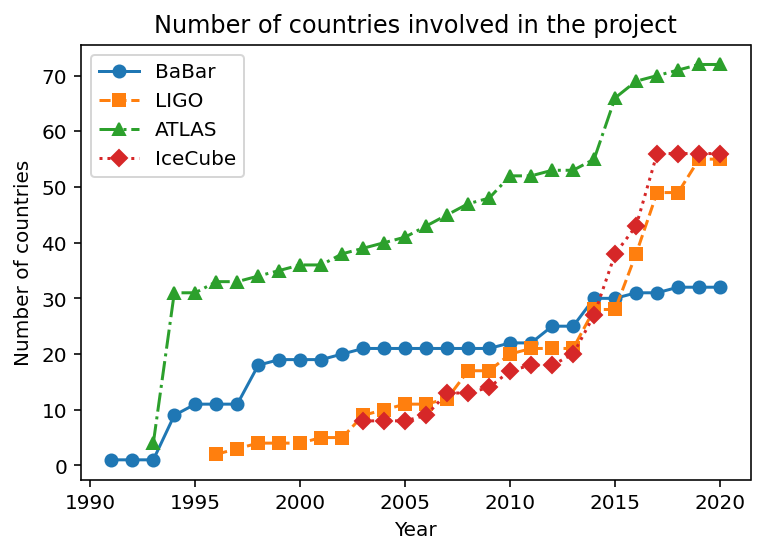

In [850]:
fig = plt.figure()
ax = plt.subplot(111)
for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  countriesByYear,averageDistanceByYear,stdDistanceByYear,years = plotDataForCollaboration[collaborationName]
  ax.plot(years,countriesByYear,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);
  
ax.legend()
ax.set_title("Number of countries involved in the project")
ax.set_xlabel("Year")
ax.set_ylabel("Number of countries")
plt.savefig("../Figures/countries.pdf")
plt.show()

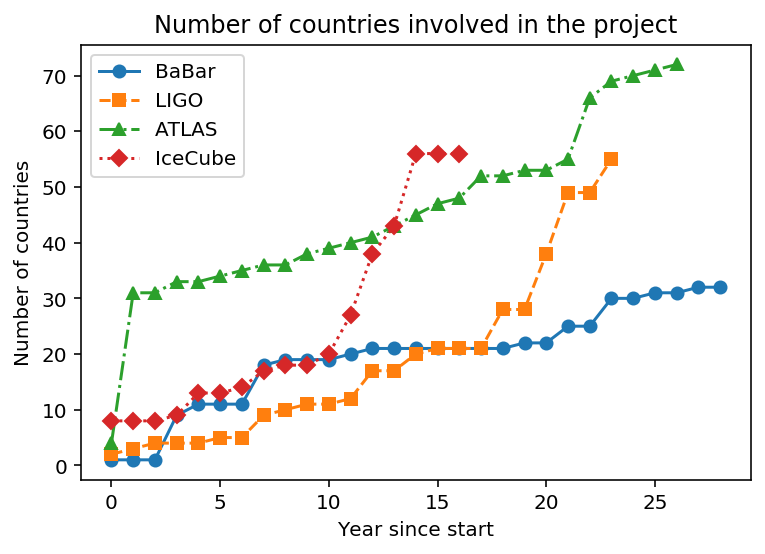

In [227]:
fig = plt.figure()
ax = plt.subplot(111)
for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  countriesByYear,averageDistanceByYear,stdDistanceByYear,years = plotDataForCollaboration[collaborationName]
  ax.plot(range(len(years)),countriesByYear,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);
  
ax.legend()
ax.set_title("Number of countries involved in the project")
ax.set_xlabel("Year since start")
ax.set_ylabel("Number of countries")
plt.savefig("../Figures/countriesSinceStart.pdf")
plt.show()

In [ ]:
fig = plt.figure(figsize=(len(consideredCollaborations)*4,3))

for plotIndex,collaborationName in enumerate(consideredCollaborations):
  ax = plt.subplot(1,len(consideredCollaborations),1+plotIndex)
  stages = projectStages[collaborationName];
  for stageIndex,(stageName,(stageStart,stageEnd)) in enumerate(stages):
    ax.axvspan(stageStart, stageEnd, color=stageColors[stageIndex], alpha=0.5,
               lw=0,ymin=0.85,ymax=0.95)
    if(stageIndex%2==0):
      textPosition = 0.84
      textAlign = "top"
    else:
      textPosition = 0.95
      textAlign = "bottom"
    ax.text((stageStart+stageEnd)/2.0,
            textPosition, stageName,
            color=stageColors[stageIndex],
            horizontalalignment='center',verticalalignment=textAlign,
            fontsize=9,
            transform=ax.get_xaxis_transform())
 
  yearsData,institutionSeries,institutionsLabels=institutionsAllData[collaborationName]
  ax.stackplot(yearsData,institutionSeries,labels=institutionsLabels);

  # box = ax.get_position()
  # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

  # # Put a legend to the right of the current axis
  # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  ax.set_title(collaborationName)
  ax.set_xlabel("Year")
  if(plotIndex==0):
    ax.set_ylabel("Num. of institutions")
    ax.legend(loc='upper left',fontsize="small",frameon=False, bbox_to_anchor=(0.0,0.8))
  else:
    ax.set_yticks([])
  plt.ylim(0,1400)
  if(plotIndex==len(consideredCollaborations)-1):
#     ax.legend(loc='upper left',fontsize="x-small",frameon=False)
    pass;
    
  
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.subplots_adjust(hspace=0.001)

plt.tight_layout()
plt.savefig("../Figures/institutions_All.pdf")
plt.show()

fig = plt.figure()
ax = plt.subplot(111)

# collaborationName = "IceCube"

citationsAndYearsByProject = {}
for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  projectCitations = citationsPerYearByProject[collaborationName]
  years = []
  citations = []
  cumulativeCitations = []
  allCitations = 0;
  startYear = 1990
  for year in sorted(projectCitations.keys()):
    allCitations+=projectCitations[year];
    if year>=startYear and year<2020:
      years.append(year);
      citations.append(projectCitations[year])
      cumulativeCitations.append(allCitations)
  citationsAndYearsByProject[collaborationName] = (years,citations)
  ax.plot(years,citations,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend()
# Put a legend to the right of the current axis
ax.set_title("Number of citations in Inspire HEP")
ax.set_xlabel("Year")
ax.set_ylabel("Number of citations")
ax.set_xlim(startYear,2020)
# ax.set_yscale("log")
plt.savefig("../Figures/yearlyCitations.pdf")
plt.show()

fig = plt.figure()
ax = plt.subplot(111)

for collaborationIndex,collaborationName in enumerate(consideredCollaborations):
  plotAuthorsYears,plotAllTimeAuthorsCount = authorAllTimeCountsByProject[collaborationName];
  ax.plot(range(1,len(plotAllTimeAuthorsCount)+1),plotAllTimeAuthorsCount,markerStyles[collaborationIndex%len(markerStyles)],label=collaborationName);
  
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Put a legend to the right of the current axis
ax.set_title("Cumulative number of authors")
ax.set_xlabel("Years since the start of the project")
ax.set_ylabel("Number of authors")
plt.tight_layout()
plt.savefig("../Figures/cumulativeAuthors.pdf")
plt.show()

In [42]:
# Recording citations to edges file
with open("../Data/toPlot/recordEdges.tsv","w") as fd:
  fd.write("\t".join(["Origin ID","Cited ID","Year"])+"\n")
  for citedID,citedData in ID2citations.items():
    for originID, year in citedData:
      fd.write("\t".join(["%d"%originID,"%d"%citedID,"%d"%year])+"\n")
    

In [907]:
import re
def canonizeName(name):
  name = name.strip("\"").strip("\'")
  name = name.lower().replace("."," ").replace("  "," ").replace("  "," ").strip()
  name = re.sub('^nat ','nature ',name)
  name = re.sub('journal ','j ',name)
  names = name.split()
  return " ".join([subname[0:3] if len(subname)==4 else subname  for subname in names])

In [ ]:
# Loading dictionaries for Journal matching
with open("../Data/ScienceMapJournalDictionary_Map2ID.json","rt") as fd:
    allToMapID = ujson.load(fd)

with open("../Data/ScienceMapJournalDictionary_Map2Name.json","rt") as fd:
    allToMapName = ujson.load(fd)

In [917]:
from collections import Counter
noMatch = Counter();
def hepName2MapName(origName):
  name = canonizeName(origName)
  if(name in allToMapName):
    return allToMapName[name];
  noMatch.update([origName]);
  return ""

def hepName2MapID(origName):
  name = canonizeName(origName)
  if(name in allToMapID):
    return allToMapID[name];
  noMatch.update([origName]);
  return ""

In [ ]:
# Saving all publication data
noMatch = Counter()
for collaborationName,entries in HEPEntriesByCollaboration.items():
  header = [
    "ID",
    "Title",
    "Type",
    "Venue Name",
    "Venue ID",
    "Venue ISBN",
    "Venue Acronym",
    "Venue Presented At",
    "Venue Extra",
    "Venue Map Name",
    "Venue Map ID",
    "Citations",
    "Author Names",
    "Author IDs",
    "Institution IDs",
    "Collaborations",
    "Experiments",
    "Classification",
    "Year"
  ]
  rows = []
  for entry in entries:

    data = [];
    propertyName = "ID"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(entry[propertyName])
    else:
      data.append("")

    propertyName = "Title"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(entry[propertyName])
    else:
      data.append("")

    propertyName = "Type"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(";".join(entry[propertyName]))
    else:
      data.append("")

    propertyName = "Venue Name"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(entry[propertyName])
    else:
      data.append("NA")

    propertyName = "Venue ID"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(entry[propertyName])
    else:
      data.append("")

    propertyName = "Venue ISBN"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(entry[propertyName])
    else:
      data.append("")

    propertyName = "Venue Acronym"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(entry[propertyName])
    else:
      data.append("")

    propertyName = "Venue Presented At"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(entry[propertyName])
    else:
      data.append("")

    propertyName = "Venue Extra"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(entry[propertyName])
    else:
      data.append("")
      

    # Map name
    propertyName = "Venue Name"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(hepName2MapName(entry[propertyName]))
    else:
      data.append("NA")

    # Map ID
    propertyName = "Venue Name"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(hepName2MapID(entry[propertyName]))
    else:
      data.append("NA")

    #Citations
    propertyName = "ID"
    if(propertyName in entry and entry[propertyName] is not None):
      entryID = int(entry[propertyName])
      if(entryID in ID2citations):
        data.append(str(len(ID2citations[entryID])));
      else:
        data.append("")
    else:
      data.append("")


    authors = [];
    if "FirstAuthor" in entry and entry["FirstAuthor"] is not None:
        authors += [entry["FirstAuthor"]];

    if "Authors" in entry and entry["Authors"] is not None:
        authors += entry["Authors"];

    institutionIDs = [str(author["Institution ID"]) for author in authors if "Institution ID" in author and author["Institution ID"] is not None]
    authorIDs = [str(author["ID"]) for author in authors if "ID" in author and author["ID"] is not None]
    authorNames = [author["Name"] for author in authors if "Name" in author and author["Name"] is not None]

    data.append(";".join(authorIDs))
    data.append(";".join(authorNames))
    data.append(";".join(institutionIDs))

    propertyName = "Collaborations"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(";".join(entry[propertyName]))
    else:
      data.append("")

    propertyName = "Experiment"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(";".join(entry[propertyName]))
    else:
      data.append("")

    propertyName = "Classification"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(";".join(entry[propertyName]))
    else:
      data.append("")

    propertyName = "Year"
    if(propertyName in entry and entry[propertyName] is not None):
      data.append(str(int(entry[propertyName])))
      if(int(entry[propertyName])<1990):
        continue;
    else:
      data.append("NA")
      continue;



    data = [str(entry).replace("\t","") for entry in data]
    data = [str(entry).replace("\n","") for entry in data]
    if(len("\t".join(data).split("\t"))!=len(header)):
      print("Problem")
    rows.append(data)
  print(collaborationName)
  df = pd.DataFrame(rows,columns=header)
  df.to_csv("../Data/Publications/Entries_%s_v5.csv"%collaborationName)

In [901]:
#saving affiliation data
import pandas as pd

affiliationsByProject = {}
for projectName in ['BaBar', 'LIGO', 'ATLAS', 'IceCube']:
    dfProject = pd.read_csv("../Data/Entries_%s.tsv"%projectName,sep="\t")
    affiliations = dfProject.groupby(['Year'])["Institution IDs"].apply(lambda x: ';'.join([entry for entry in x if isinstance(entry,str)])).reset_index()
    print(projectName)
    minYear = dfProject["Year"].min()
    maxYear = dfProject["Year"].max()
    years = []
    affiliationCounts = []
    for year in range(minYear,maxYear+1):
        yearAffiliations = list(affiliations[affiliations["Year"]==year]["Institution IDs"])
        yearAffiliationsMerge = ";".join(yearAffiliations)
        yearAffiliationsSet = set()
        for affiliationID in yearAffiliationsMerge.split(";"):
            affiliationID.strip().lower()
            if(affiliationID):
                yearAffiliationsSet.add(affiliationID);
        years.append(year)
        affiliationCounts.append(len(yearAffiliationsSet))
        print("%d\t%d"%(int(year),len(yearAffiliationsSet)))
    affiliationsByProject[projectName] = [years,affiliationCounts]
  
minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,publicationsCount)) in enumerate(affiliationsByProject.items()):
    ax.plot(years,publicationsCount,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Affiliations Count")
# plt.savefig("../../Figures/BioMedAuthorsTotal_v2.pdf")
plt.show()

with open("../Data/PlotData/Physics_AffiliationsData.json","wt") as fd:
    ujson.dump(affiliationsByProject,fd)

In [875]:
import pandas as pd

totalAffiliationsByProject = {}
for projectName in ['BaBar', 'LIGO', 'ATLAS', 'IceCube']:
    dfProject = pd.read_csv("../Data/Entries_%s.tsv"%projectName,sep="\t")
    affiliations = dfProject.groupby(['Year'])["Institution IDs"].apply(lambda x: ';'.join([entry for entry in x if isinstance(entry,str)])).reset_index()
    print(projectName)
    minYear = dfProject["Year"].min()
    maxYear = dfProject["Year"].max()
    years = []
    affiliationCounts = []
    for year in range(minYear,maxYear+1):
        yearAffiliations = list(affiliations[affiliations["Year"]<=year]["Institution IDs"])
        yearAffiliationsMerge = ";".join(yearAffiliations)
        yearAffiliationsSet = set()
        for affiliationID in yearAffiliationsMerge.split(";"):
            affiliationID.strip().lower()
            if(affiliationID):
                yearAffiliationsSet.add(affiliationID);
        years.append(year)
        affiliationCounts.append(len(yearAffiliationsSet))
        print("%d\t%d"%(int(year),len(yearAffiliationsSet)))
    totalAffiliationsByProject[projectName] = [years,affiliationCounts]
    
minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,affiliationsCount)) in enumerate(totalAffiliationsByProject.items()):
    ax.plot(years,affiliationsCount,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()

ax.set_xlabel("Year")
ax.set_ylabel("Total Affiliations Count")

plt.show()

with open("../Data/PlotData/Physics_TotalAffiliationsData.json","wt") as fd:
    ujson.dump(totalAffiliationsByProject,fd)